# Post Processing Script for EM Simulated components

In [1]:
# Import libraries
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.22f' % x)
import numpy as np
import matplotlib.pyplot as plt
import os
import scienceplots
plt.style.use(['science', 'ieee'])
# creates figs directory|
output_dir = 'figs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Harmonic Balance Simulation with EM simulated Core

## Data Extraction

In [2]:
def create_complex_data(csv_data_real, csv_data_imag):
    return [complex(real, imag) for real, imag in zip(csv_data_real, csv_data_imag)]

def convert_to_polar(complex_data):
    magnitudes = [abs(x) for x in complex_data]
    phases = [np.degrees(np.angle(x)) for x in complex_data]
    return magnitudes, phases

# Read CSV data (change paths accordingly)
Iin_csv = pd.read_csv('../../core_1/post_layout_sim/schematic/csv/IPR2.csv', delimiter=';', comment='#')
Iout_csv = pd.read_csv('../../core_1/post_layout_sim/schematic/csv/IPR3.csv', delimiter=';', comment='#')
Vin_csv = pd.read_csv('../../core_1/post_layout_sim/schematic/csv/Vin.csv', delimiter=';', comment='#')
Vout_csv = pd.read_csv('../../core_1/post_layout_sim/schematic/csv/Vout.csv', delimiter=';', comment='#')

vin_complex = create_complex_data(Vin_csv['r xyce/V(VIN)'], Vin_csv['i xyce/V(VIN)'])
vout_complex = create_complex_data(Vout_csv['r xyce/V(VOUT)'], Vout_csv['i xyce/V(VOUT)'])
Iout_complex = create_complex_data(Iout_csv['r xyce/I(PR3)'], Iout_csv['i xyce/I(PR3)'])
Iin_complex = create_complex_data(Iin_csv['r xyce/I(PR2)'], Iin_csv['i xyce/I(PR2)'])

Vin_magnitude, Vin_phase = convert_to_polar(vin_complex)
Vout_magnitude, Vout_phase = convert_to_polar(vout_complex)
Iin_magnitude, Iin_phase = convert_to_polar(Iin_complex)
Iout_magnitude, Iout_phase = convert_to_polar(Iout_complex)

power_df = pd.DataFrame({
    'Freq': Iin_csv['FREQ'],
    #'current_sweep': Iin_csv['Y'],
    'Vin_magnitude': Vin_magnitude,
    'Vin_phase': Vin_phase,
    'Vout_magnitude': Vout_magnitude,
    'Vout_phase': Vout_phase,
    'Iin_magnitude': Iin_magnitude,
    'Iin_phase': Iin_phase,
    'Iout_magnitude': Iout_magnitude,
    'Iout_phase': Iout_phase,
    # Store complex numbers as separate real and imaginary parts
    'Vin_real': [c.real for c in vin_complex],
    'Vin_imag': [c.imag for c in vin_complex],
    'Iin_real': [c.real for c in Iin_complex],
    'Iin_imag': [c.imag for c in Iin_complex]
})

def filter_df_for_freq(df, freq):
    return df[df['Freq'] == freq]

Fref_of_interest = 50e9  # Define the frequency of interest
df_50_ghz = filter_df_for_freq(power_df, Fref_of_interest)

#input_power_sweep = 10 * np.log10(((df_50_ghz['current_sweep'])**2 * 50) * 1000)

RMS = False
data = df_50_ghz.copy()
if RMS:
    Iin = df_50_ghz['Iin_magnitude'] / np.sqrt(2)
    Vin = df_50_ghz['Vin_magnitude'] / np.sqrt(2)
    Iout = df_50_ghz['Iout_magnitude'] / np.sqrt(2)
    Vout = df_50_ghz['Vout_magnitude'] / np.sqrt(2)
else:
    Iin = df_50_ghz['Iin_magnitude']
    Vin = df_50_ghz['Vin_magnitude']
    Iout = df_50_ghz['Iout_magnitude']
    Vout = df_50_ghz['Vout_magnitude']

Iin_phase = df_50_ghz['Iin_phase']
Vin_phase = df_50_ghz['Vin_phase']
Iout_phase = df_50_ghz['Iout_phase']
Vout_phase = df_50_ghz['Vout_phase']

Po_calc = 10 * np.log10((Iout * Vout * np.cos(np.radians(Vout_phase - Iout_phase))) * 1000)
Pi_calc = 10 * np.log10((Iin * Vin * np.cos(np.radians(Vin_phase - Iin_phase))) * 1000)

df_50_ghz = df_50_ghz.copy()  # Make a copy to avoid SettingWithCopyWarning
#df_50_ghz.loc[:, 'Input_Power_dbm'] = input_power_sweep
df_50_ghz.loc[:, 'Output_Power_dbm'] = Po_calc
df_50_ghz.loc[:, 'Input_power_calc_dbm'] = Pi_calc

## with calculated input power data

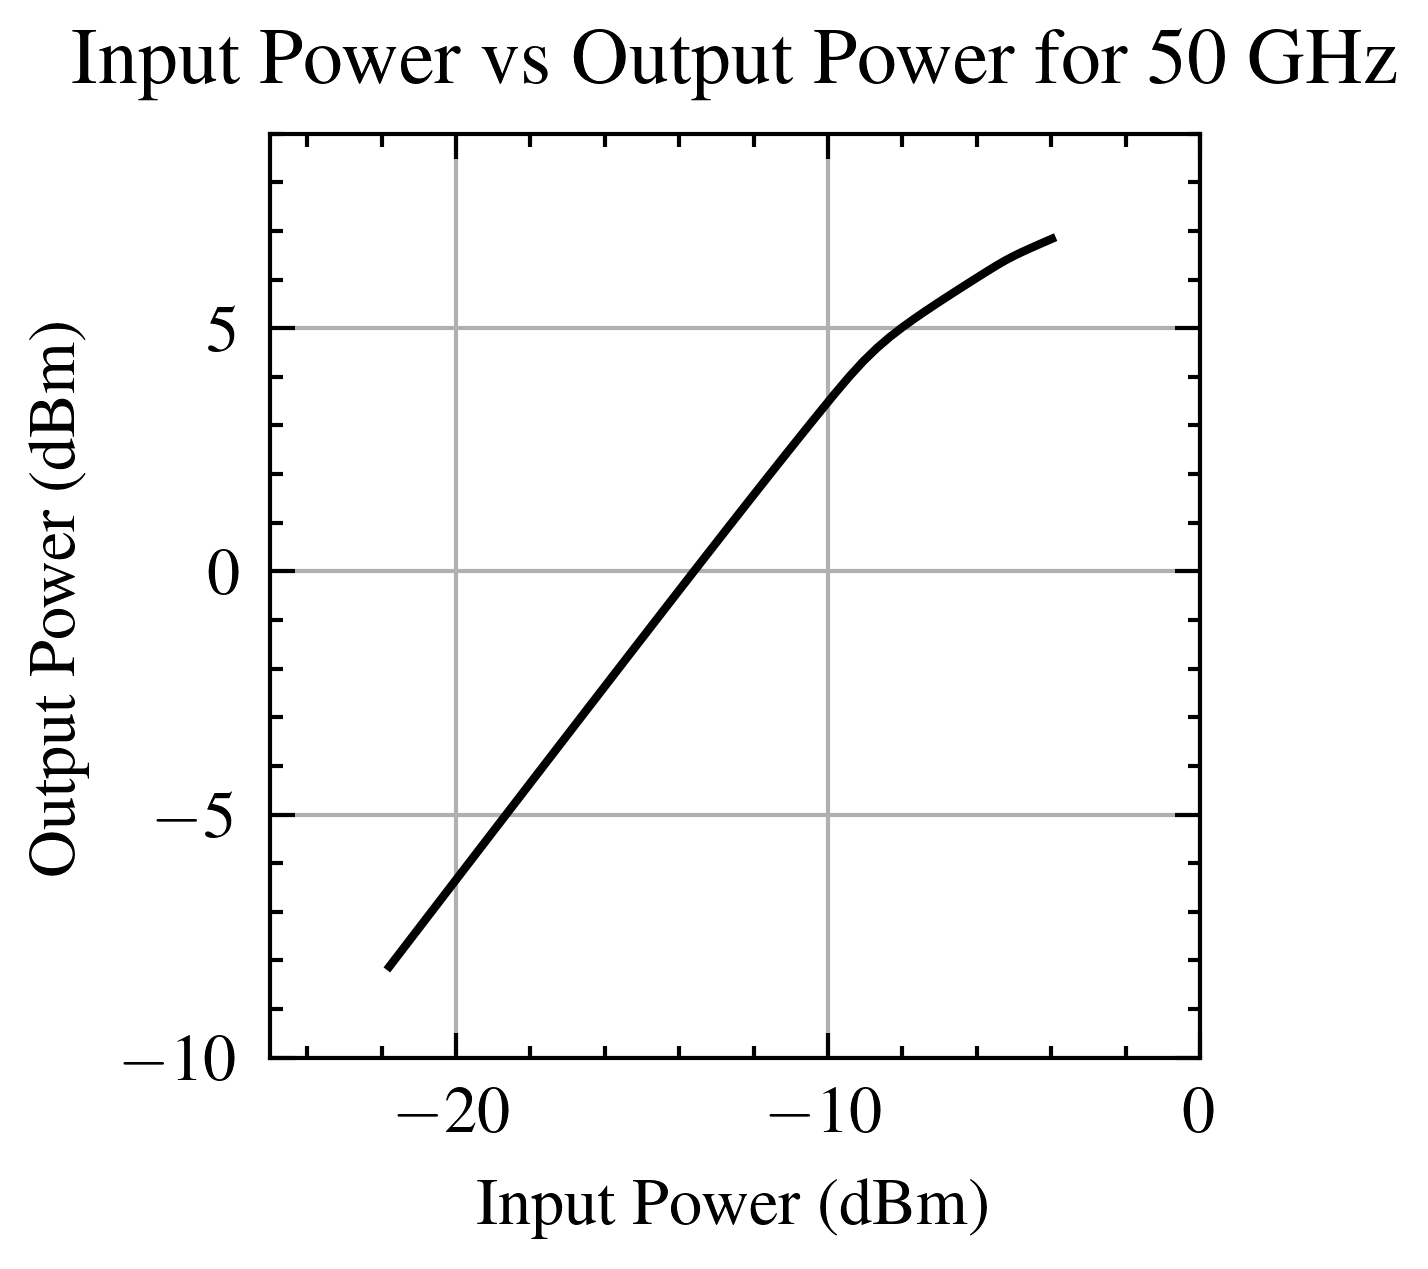

In [3]:
#plotting the Output power vs Input power for 50 GHz
plt.figure(figsize=(2, 2))
plt.plot(df_50_ghz['Input_power_calc_dbm'].values, df_50_ghz['Output_Power_dbm'].values)
plt.xlabel('Input Power (dBm)')
plt.ylabel('Output Power (dBm)')
plt.title('Input Power vs Output Power for 50 GHz')
plt.xlim(-25, 0)
plt.ylim(-10, 9)
plt.grid()
plt.savefig('figs/core/IPvsOP_core.png')
plt.show()


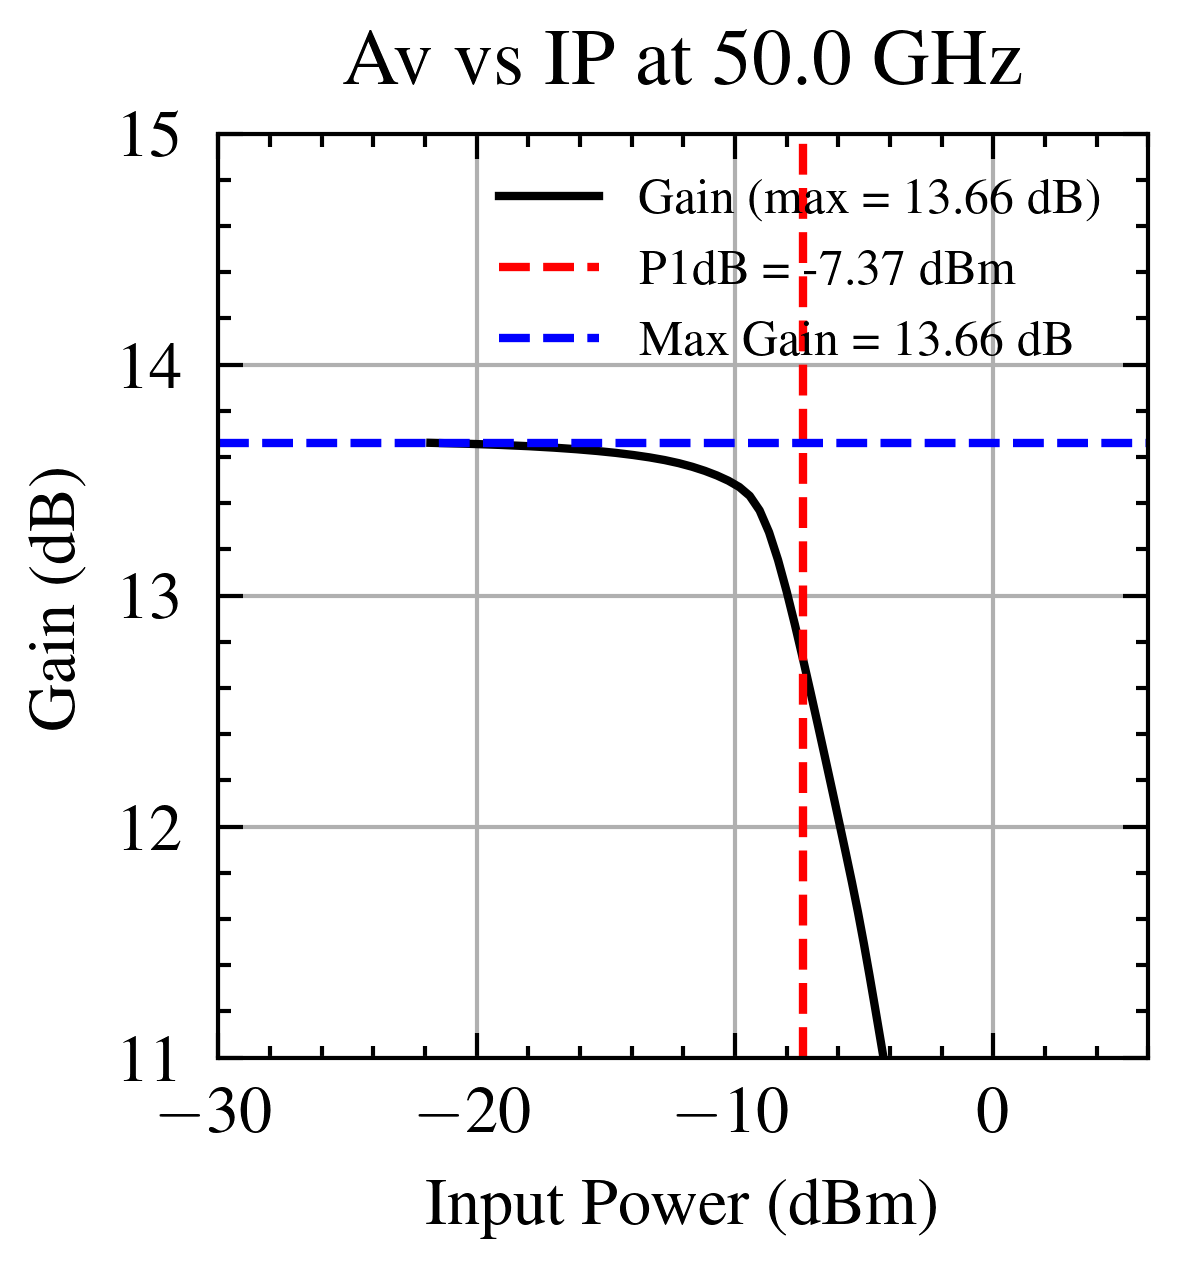

In [4]:
df_50_ghz = df_50_ghz.reset_index(drop=True)
Gain_db = df_50_ghz['Output_Power_dbm'] - df_50_ghz['Input_power_calc_dbm']
max_gain = Gain_db.max()

max_gain_final = max_gain - Gain_db - 1
P1db_curve = np.abs(max_gain_final)
P1db_index = np.argmin(P1db_curve)

Po_p1db = P1db_curve[P1db_index]
Pi_p1db = df_50_ghz['Input_power_calc_dbm'][P1db_index]
max_gain_db = max_gain

plt.figure(figsize=(2, 2))

plt.plot(df_50_ghz['Input_power_calc_dbm'].to_numpy(), Gain_db.to_numpy(), label=f'Gain (max = {max_gain_db:.2f} dB)')

plt.axvline(x=Pi_p1db, color='red', linestyle='--', label=f'P1dB = {Pi_p1db:.2f} dBm')
plt.axhline(y=max_gain_db, color='blue', linestyle='--', label=f'Max Gain = {max_gain_db:.2f} dB')

plt.xlabel("Input Power (dBm)")
plt.ylabel("Gain (dB)")
plt.title(f"Av vs IP at {50e9/1e9} GHz")

plt.xlim(-30, 6)
plt.ylim(11, 15)

plt.legend(fontsize=6)
plt.grid()
plt.savefig('figs/core/AvvsIP_core.png')
plt.show()

# Harmonic Balance Simulation with EM simulated T_connection and Core

In [5]:
# Read CSV data (change paths accordingly)
Iin_csv = pd.read_csv('../../T_connection_2/post_layout_sim/schematic/csv/IPR2.csv', delimiter=';', comment='#')
Iout_csv = pd.read_csv('../../T_connection_2/post_layout_sim/schematic/csv/IPR3.csv', delimiter=';', comment='#')
Vin_csv = pd.read_csv('../../T_connection_2/post_layout_sim/schematic/csv/Vin.csv', delimiter=';', comment='#')
Vout_csv = pd.read_csv('../../T_connection_2/post_layout_sim/schematic/csv/Vout.csv', delimiter=';', comment='#')

Fref_of_interest = 50e9 # setting to 50GHz

# Initialize an empty DataFrame with the correct number of rows based on Iin_csv
power_df = pd.DataFrame({
    'Freq': Iin_csv['FREQ'],
    'P_in': np.zeros(len(Iin_csv)),  # Preallocate with zeros
    'P_out': np.zeros(len(Iin_csv))  # Preallocate with zeros
})


In [6]:
def create_complex_data(csv_data_real, csv_data_imag):
    return [complex(real, imag) for real, imag in zip(csv_data_real, csv_data_imag)]

def convert_to_polar(complex_data):
    magnitudes = [abs(x) for x in complex_data]
    phases = [np.degrees(np.angle(x)) for x in complex_data]
    return magnitudes, phases

# Read CSV data (change paths accordingly)
Iin_csv = pd.read_csv('../../core_1/post_layout_sim/schematic/csv/IPR2.csv', delimiter=';', comment='#')
Iout_csv = pd.read_csv('../../core_1/post_layout_sim/schematic/csv/IPR3.csv', delimiter=';', comment='#')
Vin_csv = pd.read_csv('../../core_1/post_layout_sim/schematic/csv/Vin.csv', delimiter=';', comment='#')
Vout_csv = pd.read_csv('../../core_1/post_layout_sim/schematic/csv/Vout.csv', delimiter=';', comment='#')

vin_complex = create_complex_data(Vin_csv['r xyce/V(VIN)'], Vin_csv['i xyce/V(VIN)'])
vout_complex = create_complex_data(Vout_csv['r xyce/V(VOUT)'], Vout_csv['i xyce/V(VOUT)'])
Iout_complex = create_complex_data(Iout_csv['r xyce/I(PR3)'], Iout_csv['i xyce/I(PR3)'])
Iin_complex = create_complex_data(Iin_csv['r xyce/I(PR2)'], Iin_csv['i xyce/I(PR2)'])

Vin_magnitude, Vin_phase = convert_to_polar(vin_complex)
Vout_magnitude, Vout_phase = convert_to_polar(vout_complex)
Iin_magnitude, Iin_phase = convert_to_polar(Iin_complex)
Iout_magnitude, Iout_phase = convert_to_polar(Iout_complex)

power_df = pd.DataFrame({
    'Freq': Iin_csv['FREQ'],
    #'current_sweep': Iin_csv['Y'],
    'Vin_magnitude': Vin_magnitude,
    'Vin_phase': Vin_phase,
    'Vout_magnitude': Vout_magnitude,
    'Vout_phase': Vout_phase,
    'Iin_magnitude': Iin_magnitude,
    'Iin_phase': Iin_phase,
    'Iout_magnitude': Iout_magnitude,
    'Iout_phase': Iout_phase,
    # Store complex numbers as separate real and imaginary parts
    'Vin_real': [c.real for c in vin_complex],
    'Vin_imag': [c.imag for c in vin_complex],
    'Iin_real': [c.real for c in Iin_complex],
    'Iin_imag': [c.imag for c in Iin_complex]
})

def filter_df_for_freq(df, freq):
    return df[df['Freq'] == freq]

Fref_of_interest = 50e9  # Define the frequency of interest
df_50_ghz = filter_df_for_freq(power_df, Fref_of_interest)

#input_power_sweep = 10 * np.log10(((df_50_ghz['current_sweep'])**2 * 50) * 1000)

RMS = False
data = df_50_ghz.copy()
if RMS:
    Iin = df_50_ghz['Iin_magnitude'] / np.sqrt(2)
    Vin = df_50_ghz['Vin_magnitude'] / np.sqrt(2)
    Iout = df_50_ghz['Iout_magnitude'] / np.sqrt(2)
    Vout = df_50_ghz['Vout_magnitude'] / np.sqrt(2)
else:
    Iin = df_50_ghz['Iin_magnitude']
    Vin = df_50_ghz['Vin_magnitude']
    Iout = df_50_ghz['Iout_magnitude']
    Vout = df_50_ghz['Vout_magnitude']

Iin_phase = df_50_ghz['Iin_phase']
Vin_phase = df_50_ghz['Vin_phase']
Iout_phase = df_50_ghz['Iout_phase']
Vout_phase = df_50_ghz['Vout_phase']

Po_calc = 10 * np.log10((Iout * Vout * np.cos(np.radians(Vout_phase - Iout_phase))) * 1000)
Pi_calc = 10 * np.log10((Iin * Vin * np.cos(np.radians(Vin_phase - Iin_phase))) * 1000)

df_50_ghz = df_50_ghz.copy()  # Make a copy to avoid SettingWithCopyWarning
#df_50_ghz.loc[:, 'Input_Power_dbm'] = input_power_sweep
df_50_ghz.loc[:, 'Output_Power_dbm'] = Po_calc
df_50_ghz.loc[:, 'Input_power_calc_dbm'] = Pi_calc

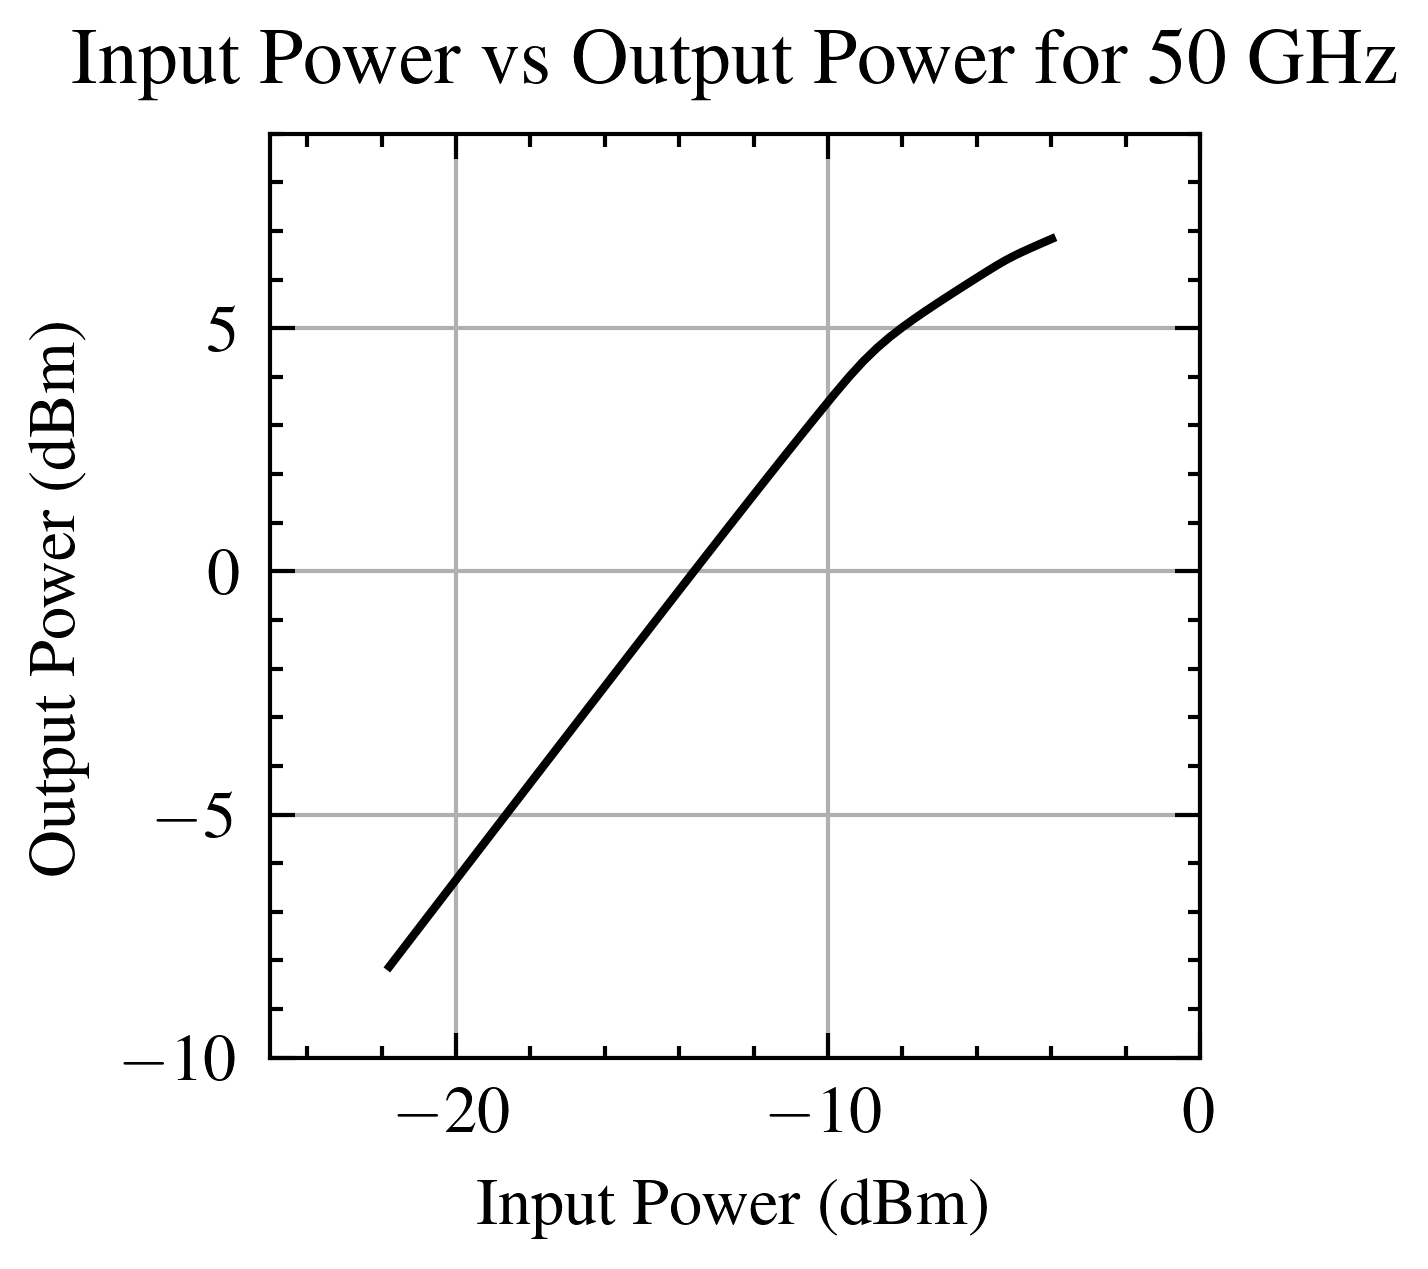

In [7]:
#plotting the Output power vs Input power for 50 GHz
plt.figure(figsize=(2, 2))
plt.plot(df_50_ghz['Input_power_calc_dbm'].values, df_50_ghz['Output_Power_dbm'].values)
plt.xlabel('Input Power (dBm)')
plt.ylabel('Output Power (dBm)')
plt.title('Input Power vs Output Power for 50 GHz')
plt.xlim(-25, 0)
plt.ylim(-10, 9)
plt.grid()
plt.savefig('figs/Tcon/IPvsOP_Tcon_core.png')
plt.show()


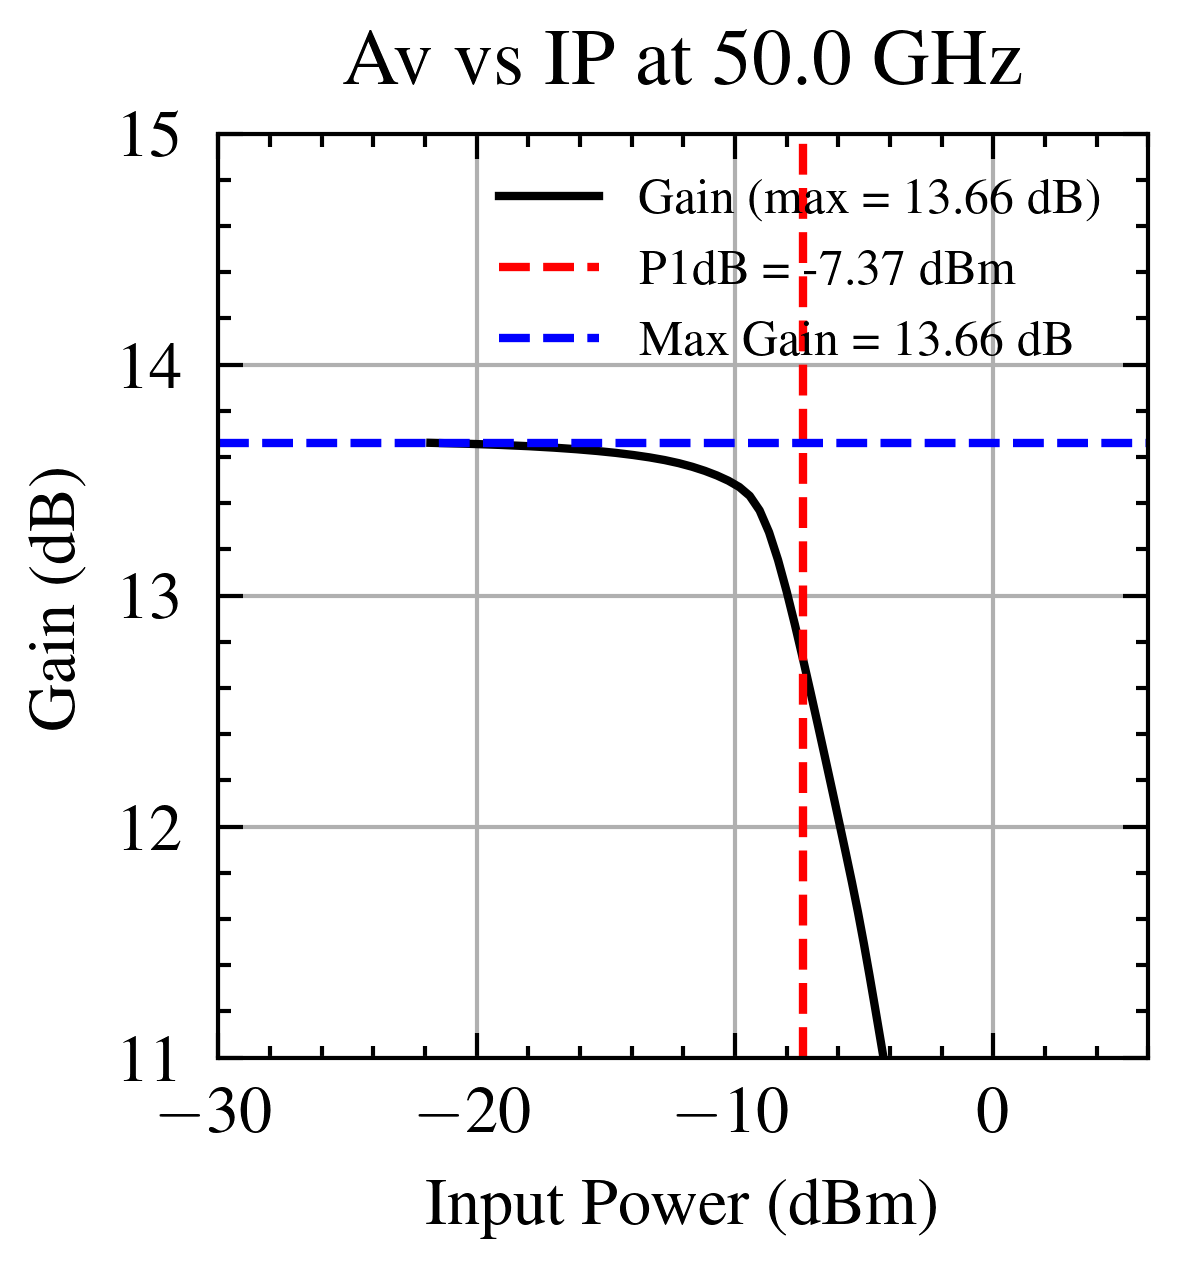

In [8]:
df_50_ghz = df_50_ghz.reset_index(drop=True)
Gain_db = df_50_ghz['Output_Power_dbm'] - df_50_ghz['Input_power_calc_dbm']
max_gain = Gain_db.max()

max_gain_final = max_gain - Gain_db - 1
P1db_curve = np.abs(max_gain_final)
P1db_index = np.argmin(P1db_curve)

Po_p1db = P1db_curve[P1db_index]
Pi_p1db = df_50_ghz['Input_power_calc_dbm'][P1db_index]
max_gain_db = max_gain

plt.figure(figsize=(2, 2))

plt.plot(df_50_ghz['Input_power_calc_dbm'].to_numpy(), Gain_db.to_numpy(), label=f'Gain (max = {max_gain_db:.2f} dB)')

plt.axvline(x=Pi_p1db, color='red', linestyle='--', label=f'P1dB = {Pi_p1db:.2f} dBm')
plt.axhline(y=max_gain_db, color='blue', linestyle='--', label=f'Max Gain = {max_gain_db:.2f} dB')

plt.xlabel("Input Power (dBm)")
plt.ylabel("Gain (dB)")
plt.title(f"Av vs IP at {50e9/1e9} GHz")

plt.xlim(-30, 6)
plt.ylim(11, 15)

plt.legend(fontsize=6)
plt.grid()
plt.savefig('figs/Tcon/AVvsIP_Tcon_core.png')
plt.show()